The field of [NILM](http://en.wikipedia.org/wiki/Nonintrusive_load_monitoring) has seen some exciting developments in the recent past. However, with the release of [nilmtk](http://nilmtk.github.io/), we are aiming to see how well different approaches line up. So, we were interested in bringing one of the [seminal work](http://georgehart.com/research/Hart1985.pdf) in NILM by [George Hart](http://georgehart.com/) to nilmtk and give it a spin. In this notebook, I'll present a very quick overview of the algorithm and test it out on a home from the [WikiEnergy](https://dataport.pecanstreet.org/) data set.

### Customary imports

In [2]:
import numpy as np
import pandas as pd
from os.path import join

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

rcParams['figure.figsize'] = (12, 6)

import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation
from nilmtk.utils import print_dict
from nilmtk.metrics import f1_score
import seaborn as sns
sns.set_palette("Set3", n_colors=12)


import warnings
warnings.filterwarnings("ignore")

### Version information

In [3]:
from nilmtk.utils import dependencies_diagnostics
pd.DataFrame(pd.Series(dependencies_diagnostics(), name="Value"))

Value
Date                                          2014-11-21 15:47:43.986384
Platform               Linux-3.13.0-39-generic-x86_64-with-debian-jes...
System version                                                       2.7
nilmtk version                                                 0.2.0.dev
nilm_metadata version                                  0.2.0.dev-2a1e9f7
Numpy version                                                      1.9.0
Matplotlib version                                                 1.3.1
Pandas version                                                    0.15.0
Scikit-learn version                                              0.14.1

### Loading data

In [4]:
data_dir = '/home/nipun/datasets/'
we = DataSet(join(data_dir, 'wikienergy.h5'))
print('loaded ' + str(len(we.buildings)) + ' buildings')

loaded 239 buildings


### Examine metadata for a single house

In [5]:
building_number = 11
print_dict(we.buildings[building_number].metadata)

### Let us perform our analysis on the first 2 days

In [6]:
we.store.window = TimeFrame(start='2014-04-01 00:00:00-05:00', end='2014-04-02 00:00:00-05:00')
elec = we.buildings[building_number].elec
elec.appliances

[Appliance(type='fridge', instance=1),
 Appliance(type='dish washer', instance=1),
 Appliance(type='electric water heating appliance', instance=1),
 Appliance(type='spin dryer', instance=1),
 Appliance(type='electric furnace', instance=1),
 Appliance(type='sockets', instance=1),
 Appliance(type='sockets', instance=2),
 Appliance(type='air conditioner', instance=1),
 Appliance(type='sockets', instance=3),
 Appliance(type='sockets', instance=4)]

In [7]:
mains = elec.mains()

Let us quickly have a look at what contribution different appliances have to the mains.

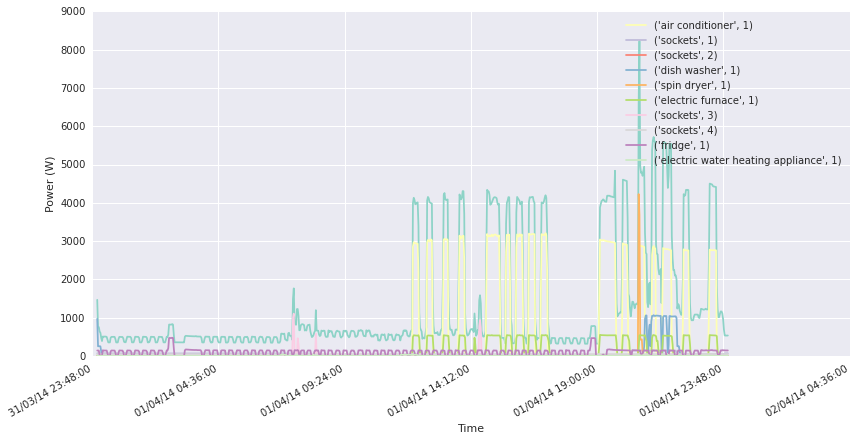

In [8]:
elec.plot()
plt.tight_layout()
plt.ylabel("Power (W)")
plt.xlabel("Time");

From the plot above, a human could easily see the signature of 3 appliances: `Fridge`, `Air conditioner` and `Electric furnace`
    
We'll hope that our unsupervised implementation would be able to figure out these 3 appliances.    

1/10 ElecMeter(instance=2, building=11, dataset='WikiEnergy', appliances=[Appliance(type='air conditioner', instance=1)])Using cached result from metadata.
2/10 ElecMeter(instance=3, building=11, dataset='WikiEnergy', appliances=[Appliance(type='sockets', instance=1)])Using cached result from metadata.
3/10 ElecMeter(instance=4, building=11, dataset='WikiEnergy', appliances=[Appliance(type='sockets', instance=2)])Using cached result from metadata.
4/10 ElecMeter(instance=5, building=11, dataset='WikiEnergy', appliances=[Appliance(type='dish washer', instance=1)])Using cached result from metadata.
5/10 ElecMeter(instance=6, building=11, dataset='WikiEnergy', appliances=[Appliance(type='spin dryer', instance=1)])Using cached result from metadata.
6/10 ElecMeter(instance=7, building=11, dataset='WikiEnergy', appliances=[Appliance(type='electric furnace', instance=1)])Using cached result from metadata.
7/10 ElecMeter(instance=8, building=11, dataset='WikiEnergy', appliances=[Appliance(type

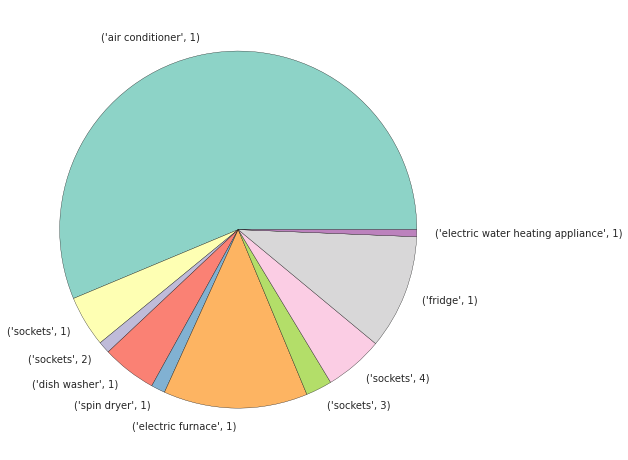

In [9]:
fraction = elec.submeters().fraction_per_meter().dropna()
labels = elec.get_appliance_labels(fraction.index)
plt.figure(figsize=(8,8))
fraction.plot(kind='pie', labels=labels);

The air conditioner, fridge and electric furnace together consume around 80% of total energy.

### Training

We'll now do the training from the aggregate data. The algorithm segments the time series data into steady and transient states. Thus, we'll first figure out the transient and the steady states. Next, we'll try and pair the on and the off transitions based on their proximity in time and value. 

In [10]:
from nilmtk.disaggregate.hart_85 import Hart85
h = Hart85()

In [11]:
h.train(mains)

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.


We obtain the set of steady states as follows (only top 10 entries shown for ease of view)

In [12]:
h.steady_states.head()

active average
2014-04-01 00:00:00-05:00      755.500000
2014-04-01 00:06:00-05:00      607.500000
2014-04-01 00:09:00-05:00      505.250000
2014-04-01 00:25:00-05:00      358.666667
2014-04-01 00:31:00-05:00      502.090909

The table above shows the steady power states observed in the mains data. Another way of understanding the same is by looking at the start of steady states overlayed on top of mains power consumption, shown as follows.

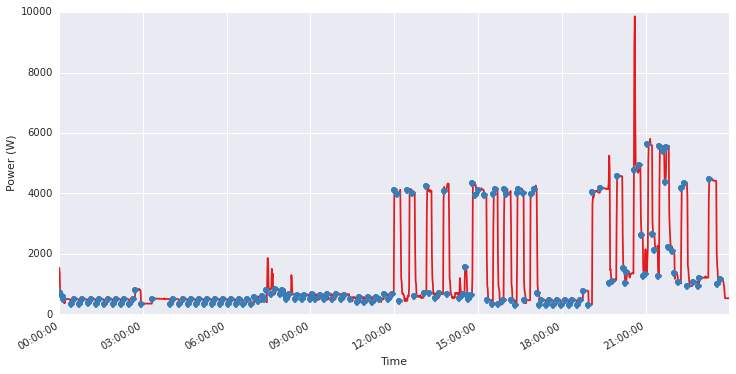

In [13]:
sns.set_palette("Set1", n_colors=12)
ax = mains.plot()
h.steady_states['active average'].plot(style='o', ax = ax);
plt.ylabel("Power (W)")
plt.xlabel("Time");

The difference b/w successive steady states gives us the transitions b/w them. The following table shows the obtained transitions (again only top 10 entries shown).

In [14]:
h.transients.head()

active transition
2014-04-01 00:00:00-05:00         755.500000
2014-04-01 00:06:00-05:00        -148.000000
2014-04-01 00:09:00-05:00        -102.250000
2014-04-01 00:25:00-05:00        -146.583333
2014-04-01 00:31:00-05:00         143.424242

These transitions when seen on the time series would appear as follows:

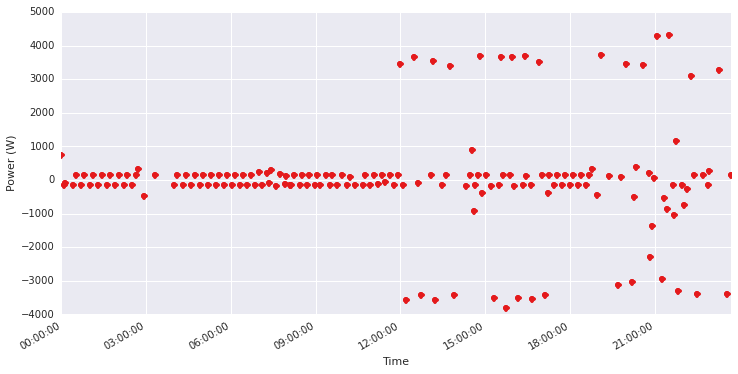

In [15]:
h.transients['active transition'].plot(style='o')
plt.ylabel("Power (W)")
plt.xlabel("Time");

Next, we pair the on (positive) and the off (negative) transitions as shown in the table below.

In [16]:
h.pair_df.head()

T1 Time   T1 Active             T2 Time   T2 Active
0 2014-04-01 05:31:00  143.424242 2014-04-01 05:43:00 -145.690909
1 2014-04-01 05:49:00  144.145455 2014-04-01 06:01:00 -138.212121
2 2014-04-01 06:08:00  141.484848 2014-04-01 06:19:00 -145.984848
3 2014-04-01 06:26:00  144.766667 2014-04-01 06:37:00 -145.600000
4 2014-04-01 06:44:00  145.600000 2014-04-01 06:55:00 -143.100000

The following image borrowed from Hart's paper summarises the above discussion.

![](http://i.imgur.com/vU2ZgD4.png)

Once, we obtain these pairings, we consider a particular appliance usage as the average of the magnitude of the on and the off transition. Then, we use a non-parametric clustering method to obtain the number of appliances and the corresponding power draws. This step in our implementation is different from what was originally proposed by George Hart. Once done, we obtain the learnt appliances as follows:

In [17]:
h.centroids

active
0   146.458708
1  3532.218934
2   911.500000

So, we obtain 3 appliances as per our unsupervised learning algorithm. Based on the power draw, I think I see air conditioner and refrigerator there. What is the third one? Not sure.

### Disaggregation

Disaggregation follows much of the same method as training. During disaggregation, we also assign transients from the learnt model.

In [18]:
disag_filename = join(data_dir, 'wikienergy-disag.h5')
output = HDFDataStore(disag_filename, 'w')
h.disaggregate(mains, output)

Finding Edges, please wait ...
Edge detection complete.
Creating transition frame ...
Transition frame created.
Creating states frame ...
States frame created.
Finished.
States done
0
1
2


In [19]:
output.close()

### Comparison with ground truth

Since we used an unsupervised approach, we don't have labels (as of yet) for the learnt appliances. Thus, we can't directly use accuracy metrics directly (as of yet, maybe in a newer version we can). I'll compare the power draw using our disaggregation with ground truth manually.

In [20]:
disag = DataSet(disag_filename)
disag_elec = disag.buildings[building_number].elec

Comparing for Fridge

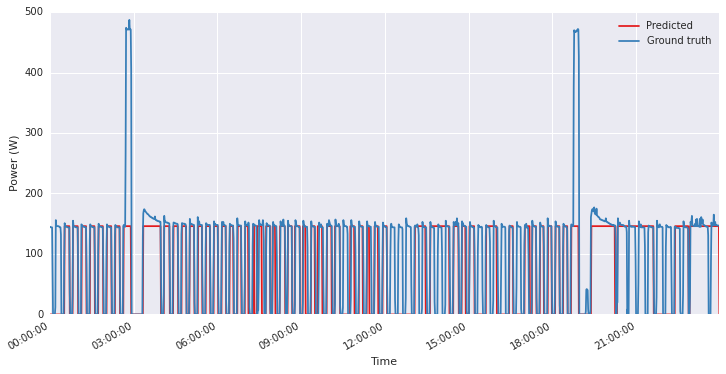

In [21]:
ax1 = disag_elec['unknown', 0].plot()
ax2 = elec['fridge', 1].plot()
ax1.legend(["Predicted", "Ground truth"]);
plt.ylabel("Power (W)")
plt.xlabel("Time");

Comparing for air conditioner

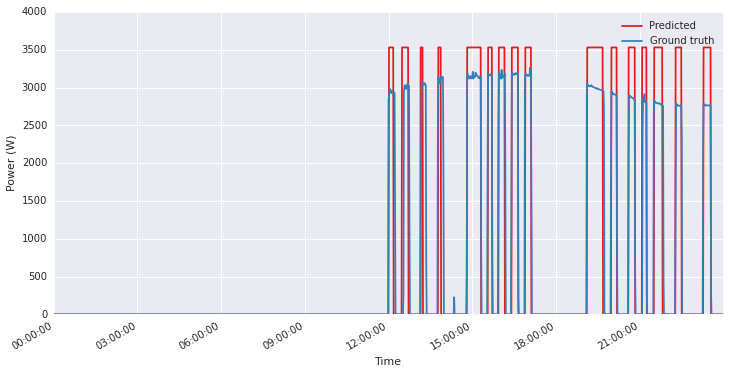

In [22]:
ax1 = disag_elec['unknown', 1].plot()
ax2 = elec['air conditioner', 1].plot()
ax1.legend(["Predicted", "Ground truth"]);
plt.ylabel("Power (W)")
plt.xlabel("Time");

While the timing looks impeccable, there seems to be some ambiguity in the power measurement :(

Comparing for the `unknown` appliance

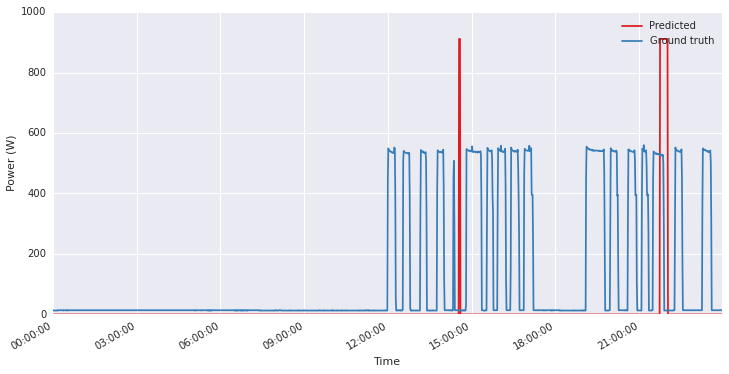

In [23]:
ax1 = disag_elec['unknown', 2].plot()
ax2 = elec['electric furnace', 1].plot()
ax1.legend(["Predicted", "Ground truth"]);
plt.ylabel("Power (W)")
plt.xlabel("Time");

So, this doesn't look to be a good fit. Maybe, the dish washer?

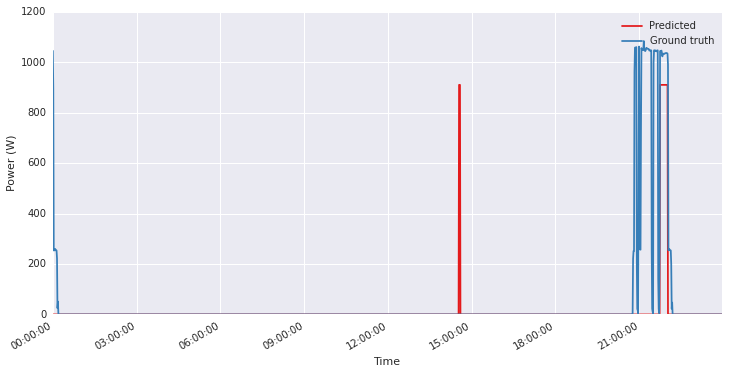

In [24]:
ax1 = disag_elec['unknown', 2].plot()
ax2 = elec['dish washer', 1].plot()
ax1.legend(["Predicted", "Ground truth"]);
plt.ylabel("Power (W)")
plt.xlabel("Time");

Probably, a decent fit. Not really sure though!

Broadly speaking, this 30 year algorithm seems to be doing a fairly decent job. The fact that this is unsupervised makes it all the more useful. There is some more work to be done on this algorithm. So, watch out for more posts and updates. Looking forward to your comments and feedback.